In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils.np_utils import to_categorical   
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from train_once import train_random_image
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import boto3
import importlib
from sklearn.model_selection import train_test_split
import json

# import customized functions
import utils

# import external losses 
# to be double checked
from losses import binary_dice_coef_loss, binary_focal_loss

# reload utils to update changes of .py file
importlib.reload(utils)

#### Define losses and metrics 

In [3]:
# define other losses and coefficients
# to be double checked

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred) 

def jacard_loss(y_true, y_pred, smooth=1e-5):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) #* smooth
    return tf.reduce_mean(jd)

#### Get list containing labels and images IDs

In [10]:
prefix = 'data_forest_20_85'
#Get images
labels_id = glob.glob(prefix+'/labels/*.npy')
images_id = glob.glob(prefix+'/images/*.npy')
list_id = np.intersect1d([image[-21:] for image in images_id],
                         [label[-21:] for label in labels_id])
n_samples = len(list_id)

#### Define UNET for binary semantic segmentation

Define a function that build the UNET. 2 generators are created, one for the training and one for the testing data. run_model() saves the model loss to a logger at every epoch.

In [11]:
def run_model(list_id, train_indexes, test_indexes,
              loss_name = "jacard_loss",
              loss = jacard_loss,prefix=prefix,
              batch_size=32, img_dim = 256,
              epochs = 5, n_channels = 6):
    steps = len(train_indexes)//batch_size
    input_shape = (img_dim, img_dim, n_channels)
    
    train_generator = utils.DataGenerator(
        list_id[train_indexes],
        batch_size=batch_size,
        prefix = prefix,
        n_channels = n_channels
    )

    test_generator = utils.DataGenerator(
        list_id[test_indexes],
        batch_size=batch_size,
        prefix = prefix,
        n_channels = n_channels
    )


    #val generator
    model = utils.build_unet(input_shape)
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = [loss],
                  metrics=[jacard_coef, 'accuracy', 'binary_crossentropy'])

    history = model.fit(train_generator,
                        validation_data=test_generator,
                        epochs=epochs,
                        steps_per_epoch = steps,
                       callbacks=[Logger(loss_name)])
    
    return history, model


Define a logger. This will update a .csv file once every epoch is compleated.

In [9]:
class Logger(keras.callbacks.Callback):
    
    def __init__(self, loss_function_name):
        super().__init__()
        self.loss_name = loss_function_name
        
    def on_train_begin(self, logs=None):
        with open('logger.txt', 'a') as f:
            f.write(f"===================== START: {self.loss_name} ======================\n")
            
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        with open('logger.txt', 'a') as f:
            f.write(f"Epoch {epoch}/50. Val Jaccard Coef: {logs['val_jacard_coef']}\n")
       
    def on_train_end(self, logs=None):
        with open('logger.txt', 'a') as f:
            f.write(f"======================= END: {self.loss_name} =======================\n")
    

#### Run model

Run 3 models, each with a different loss: jacard, dice and focal. Use a train/test ratio of 80/20. Save history and model to file.

In [ ]:
losses = {
    "jacard" : jacard_loss,
    "dice_loss" : binary_dice_coef_loss(),
    "focal_loss" : binary_focal_loss(0.25),
}

train_indexes, test_indexes = train_test_split(np.arange(n_samples),
                                               test_size=0.2,
                                              shuffle = True)

for loss_name in losses.keys():
    hist,model = run_model(list_id,
                           train_indexes,
                           test_indexes,
                           loss_name = loss_name,
                           loss=losses[loss_name],
                           epochs = 40
                    )
    with open(f'models/{loss_name}.json', 'w') as fp:
        json.dump(hist.history, fp)
    model.save(f"models/{loss_name}")

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 67.0354 - jacard_coef: 0.3387 - accuracy: 0.5139 - binary_crossentropy: 0.6931 

#### Model predict

read model from file

In [ ]:
model = keras.models.load_model("models/jacard",
                               compile=False)

Predict on a random image from the dataset

1/1 [==============================] - 0s 134ms/step


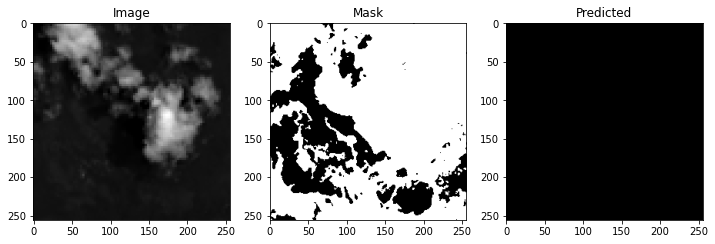

In [21]:
ID = random.choice(list_id)

fig, axs = plt.subplot_mosaic("ABC", figsize=(12,8))
axs["A"].imshow(np.load(prefix+'/images/image_' + ID)[1], cmap="gray")
axs["A"].set_title("Image")

axs["B"].imshow((y_train.reshape(256,256)>=0.5).astype(int), cmap="gray")
axs["B"].set_title("Mask")

y_preds = model.predict(X_train).reshape(256,256)
axs["C"].imshow(y_preds, cmap="gray")
axs["C"].set_title("Predicted")
plt.show()